In [1]:
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import tifffile
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.data.user_points as points
import mushroom.data.he as he
import mushroom.data.multiplex as multiplex
import mushroom.data.xenium as xenium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/examples/full_workflow'
mushroom_dir = os.path.join(run_dir, f'mushroom_points') # where mushroom results will be saved
Path(mushroom_dir).mkdir(parents=True, exist_ok=True)

## specify inputs

In [18]:
metadata = yaml.safe_load(open(os.path.join(run_dir, 'registered', 'metadata.yaml')))
yaml.safe_dump(metadata, sys.stdout)

resolution: 1.0
sections:
- data:
  - dtype: visium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad
  - dtype: he
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif
  position: 0
  sid: S18-9906-U1
- data:
  - dtype: xenium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad
  position: 5
  sid: S18-9906-U2
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s2_S18-9906-U3_multiplex.ome.tiff
  position: 10
  sid: S18-9906-U3
- data:
  - dtype: xenium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s3_S18-9906-U9_xenium.h5ad
  position: 40
  sid: S18-9906-U9
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s4_S18-9906-U10_multiplex.ome.tiff
  positi

In [19]:
# add some extra data that is offset by 1 position to each dtype and rename the identifier
dtypes = sorted(set([item['dtype'] for entry in metadata['sections'] for item in entry['data']]))
dtypes

['he', 'multiplex', 'visium', 'xenium']

In [20]:
# for dtype in dtypes:
#     dtype_identifier = f'shiitake_{dtype}'
for i in range(len(metadata['sections'])):
    entry = deepcopy(metadata['sections'][i])
    entry['sid'] = entry['sid'] + '_shiitake' # rename id
    entry['position'] += 1 # add 1 to position
    for item in entry['data']:
        item['dtype'] = 'shiitake_' + item['dtype']
    metadata['sections'].append(entry)
metadata['sections'] = sorted(metadata['sections'], key=lambda x: x['position'])
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'shiitake_visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'shiitake_he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 1,
   'sid': 'S18-9906-U1_shiitake'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad'}],
   'position': 5,
   'sid': 'S18-9906-U2'},
  {'data': [{'dtype': 'shiitake_xenium',
     'filepath': '/data/estorrs/mushroom/dat

In [21]:
DEFAULT_CONFIG

{'sections': None,
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'tiling_method': 'radius'}}},
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution': 1.0,
  'target_resolution': 0.02,
  'pct_expression': 0.05,
  'log_base': 2.718281828459045,
  'tiling_method': 'grid',
  'tiling_radius': 1.0,
  'batch_size': 128,
  'num_workers': 0,
  'devices': 1,
  'accelerator': 'cpu',
  'max_epochs': 1,
  'steps_per_epoch': 1000,
  'lr': 0.0001,
  'out_dir': './outputs',
  'save_every': 1,
  'log_every_n_steps': 10,
  'logger_type': 'tensorboard',
  'logger_project': 'portobello',
  'channel_mapping': {},
  'data

In [22]:
config = deepcopy(DEFAULT_CONFIG)
config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': metadata['resolution'] / 50.,
        'out_dir': os.path.join(mushroom_dir, 'outputs'),
        'accelerator': 'gpu',
        'steps_per_epoch': 50,
    }
})
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'shiitake_visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'shiitake_he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 1,
   'sid': 'S18-9906-U1_shiitake'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad'}],
   'position': 5,
   'sid': 'S18-9906-U2'},
  {'data': [{'dtype': 'shiitake_xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/

In [15]:
# fps = [mapping['filepath'] 
#        for item in config['sections']
#        for mapping in item['data']
#        if 'multiplex' == mapping['dtype']]
# multiplex.get_channel_counts(fps)

In [23]:
config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
    'visium': {
        'trainer_kwargs': {
            'target_resolution': .01 # lower resolution for visium
        }
    },
    'shiitake_visium': {
        'trainer_kwargs': {
            'target_resolution': .01, # lower resolution for visium
            'tiling_method': 'radius',
        }
    }
})
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'shiitake_visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'shiitake_he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 1,
   'sid': 'S18-9906-U1_shiitake'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad'}],
   'position': 5,
   'sid': 'S18-9906-U2'},
  {'data': [{'dtype': 'shiitake_xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/

## train mushroom

In [28]:
mushroom = Mushroom.from_config(config)

INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['S18-9906-U1', 'S18-9906-U16']
INFO:root:processing sections
INFO:root:generating image data for section S18-9906-U1
INFO:root:generating image data for section S18-9906-U16
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('S18-9906-U1', 'he'), ('S18-9906-U16', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['S18-9906-U3', 'S18-9906-U10', 'S18-9906-U18', 'S18-9906-U25']
INFO:root:processing sections
INFO:root:generating image data for secti

In [29]:
mushroom.section_ids

[('S18-9906-U1', 'visium'),
 ('S18-9906-U1', 'he'),
 ('S18-9906-U1_shiitake', 'shiitake_visium'),
 ('S18-9906-U1_shiitake', 'shiitake_he'),
 ('S18-9906-U2', 'xenium'),
 ('S18-9906-U2_shiitake', 'shiitake_xenium'),
 ('S18-9906-U3', 'multiplex'),
 ('S18-9906-U3_shiitake', 'shiitake_multiplex'),
 ('S18-9906-U9', 'xenium'),
 ('S18-9906-U9_shiitake', 'shiitake_xenium'),
 ('S18-9906-U10', 'multiplex'),
 ('S18-9906-U10_shiitake', 'shiitake_multiplex'),
 ('S18-9906-U16', 'visium'),
 ('S18-9906-U16', 'he'),
 ('S18-9906-U16_shiitake', 'shiitake_visium'),
 ('S18-9906-U16_shiitake', 'shiitake_he'),
 ('S18-9906-U17', 'xenium'),
 ('S18-9906-U17_shiitake', 'shiitake_xenium'),
 ('S18-9906-U18', 'multiplex'),
 ('S18-9906-U18_shiitake', 'shiitake_multiplex'),
 ('S18-9906-U24', 'xenium'),
 ('S18-9906-U24_shiitake', 'shiitake_xenium'),
 ('S18-9906-U25', 'multiplex'),
 ('S18-9906-U25_shiitake', 'shiitake_multiplex')]

In [30]:
mushroom.train()

INFO:root:starting training for he
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/he_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.868    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/he_chkpts/last-v3.ckpt
INFO:root:starting training for multiplex
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/multiplex_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.914    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/multiplex_chkpts/last-v1.ckpt
INFO:root:starting training for shiitake_he
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.868    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training shiitake_he, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/shiitake_he_chkpts/last.ckpt
INFO:root:starting training for shiitake_multiplex
Missing logger folder: /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/shiitake_multiplex_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.914    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training shiitake_multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/shiitake_multiplex_chkpts/last.ckpt
INFO:root:starting training for shiitake_visium
Missing logger folder: /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/shiitake_visium_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 24.8 M
------------------------------
24.8 M    Trainable params
0         Non-trainable params
24.8 M    Total params
99.234    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training shiitake_visium, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/shiitake_visium_chkpts/last.ckpt
INFO:root:starting training for shiitake_xenium
Missing logger folder: /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/shiitake_xenium_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.838    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training shiitake_xenium, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/shiitake_xenium_chkpts/last.ckpt
INFO:root:starting training for visium
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/visium_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 24.8 M
------------------------------
24.8 M    Trainable params
0         Non-trainable params
24.8 M    Total params
99.234    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training visium, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/visium_chkpts/last-v1.ckpt
INFO:root:starting training for xenium
Missing logger folder: /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/xenium_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.838    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/xenium_chkpts/last.ckpt


In [31]:
mushroom.embed_sections()

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding shiitake_he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding shiitake_multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding shiitake_visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding shiitake_xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

he


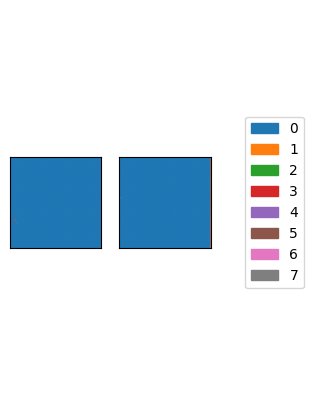

multiplex


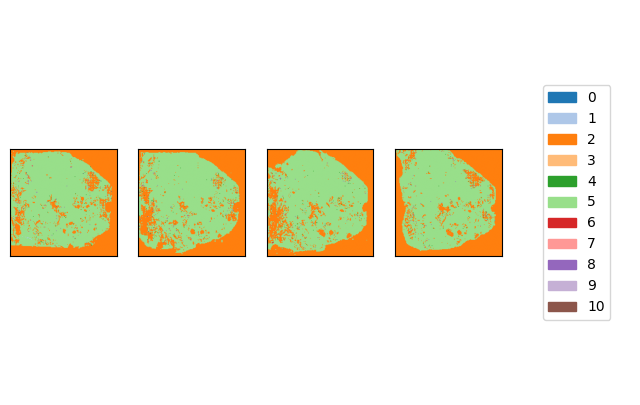

shiitake_he


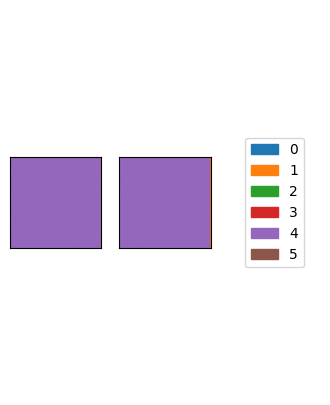

shiitake_multiplex


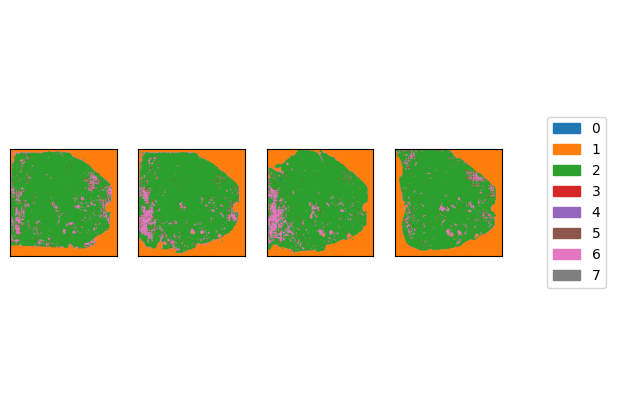

shiitake_visium


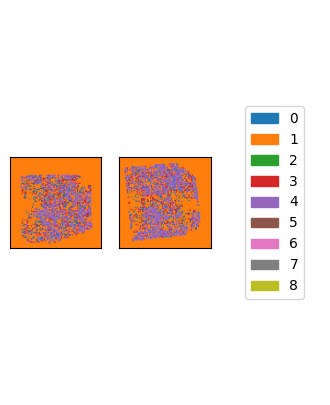

shiitake_xenium


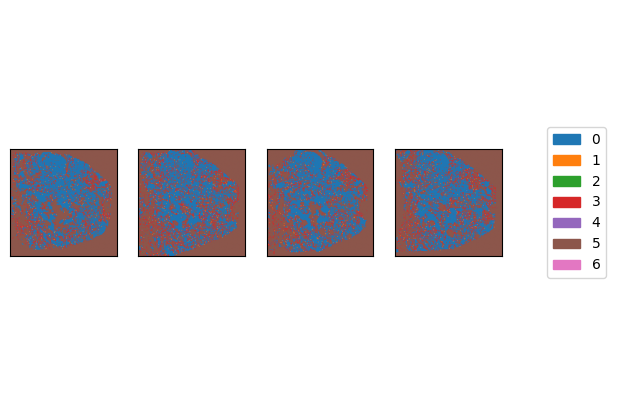

visium


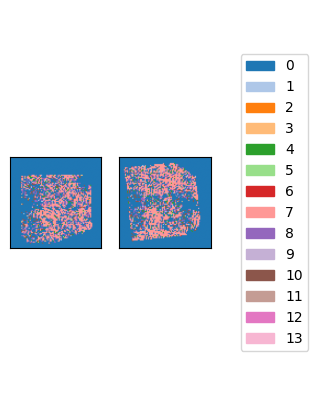

xenium


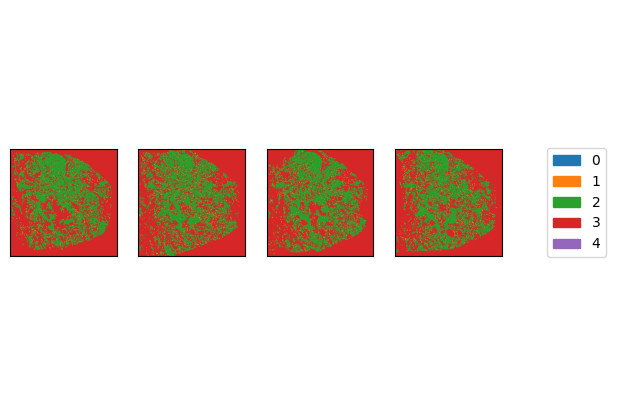

In [32]:
for dtype in mushroom.dtypes:
    print(dtype)
    mushroom.display_clusters(dtype)
    plt.show()

In [34]:
mushroom.dtypes

['he',
 'multiplex',
 'shiitake_he',
 'shiitake_multiplex',
 'shiitake_visium',
 'shiitake_xenium',
 'visium',
 'xenium']

he


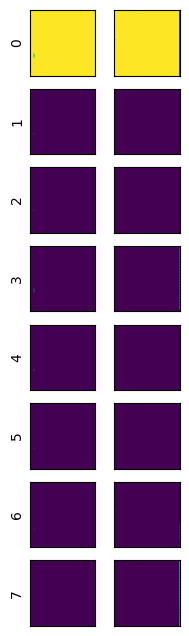

multiplex


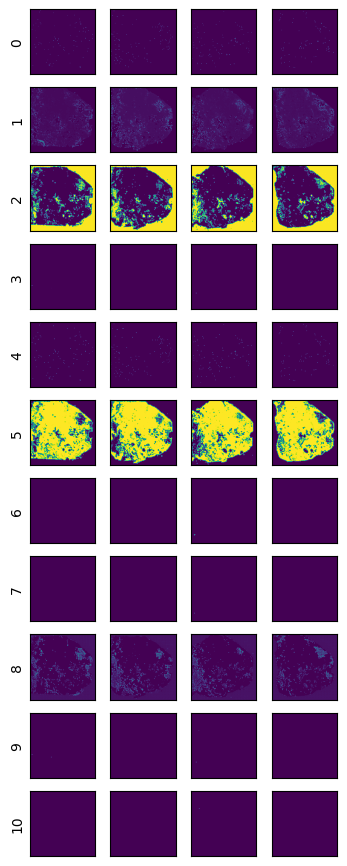

shiitake_he


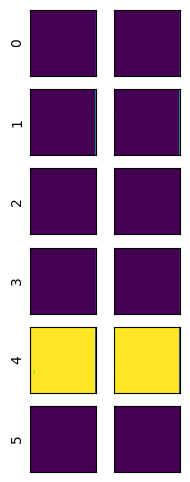

shiitake_multiplex


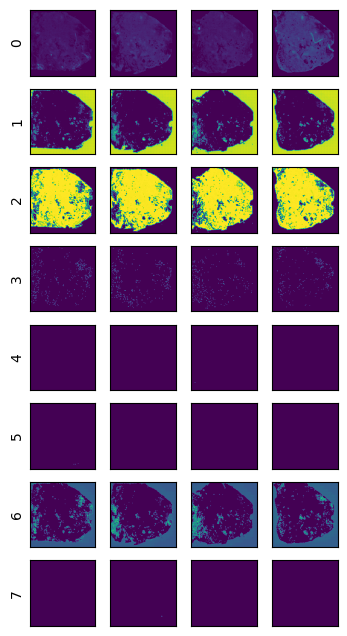

shiitake_visium


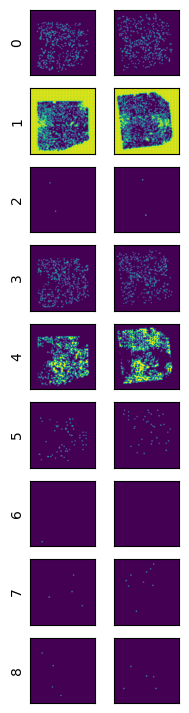

shiitake_xenium


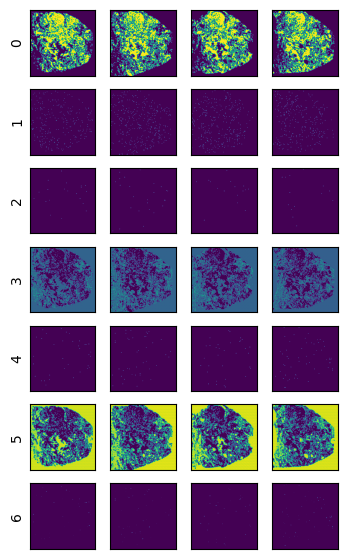

visium


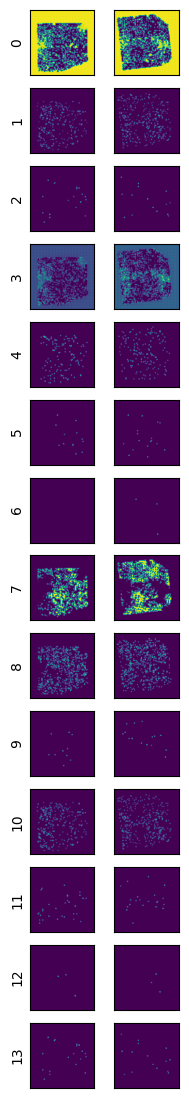

xenium


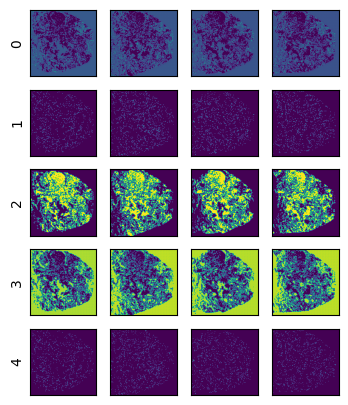

In [33]:
for dtype in mushroom.dtypes:
    print(dtype)
    mushroom.display_cluster_probs(dtype)
    plt.show()

In [40]:
%%time
z_scaler = .1
cluster_res = 1.5
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=0, resolution=cluster_res)

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for shiitake_he spore
INFO:root:generating volume for shiitake_multiplex spore
INFO:root:generating volume for shiitake_visium spore
INFO:root:generating volume for shiitake_xenium spore
INFO:root:generating volume for visium spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 61009 edges
INFO:root:4465 edges remaining after filtering
INFO:root:247 of 247 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 7 clusters


CPU times: user 41min 3s, sys: 11min 9s, total: 52min 12s
Wall time: 1min 45s


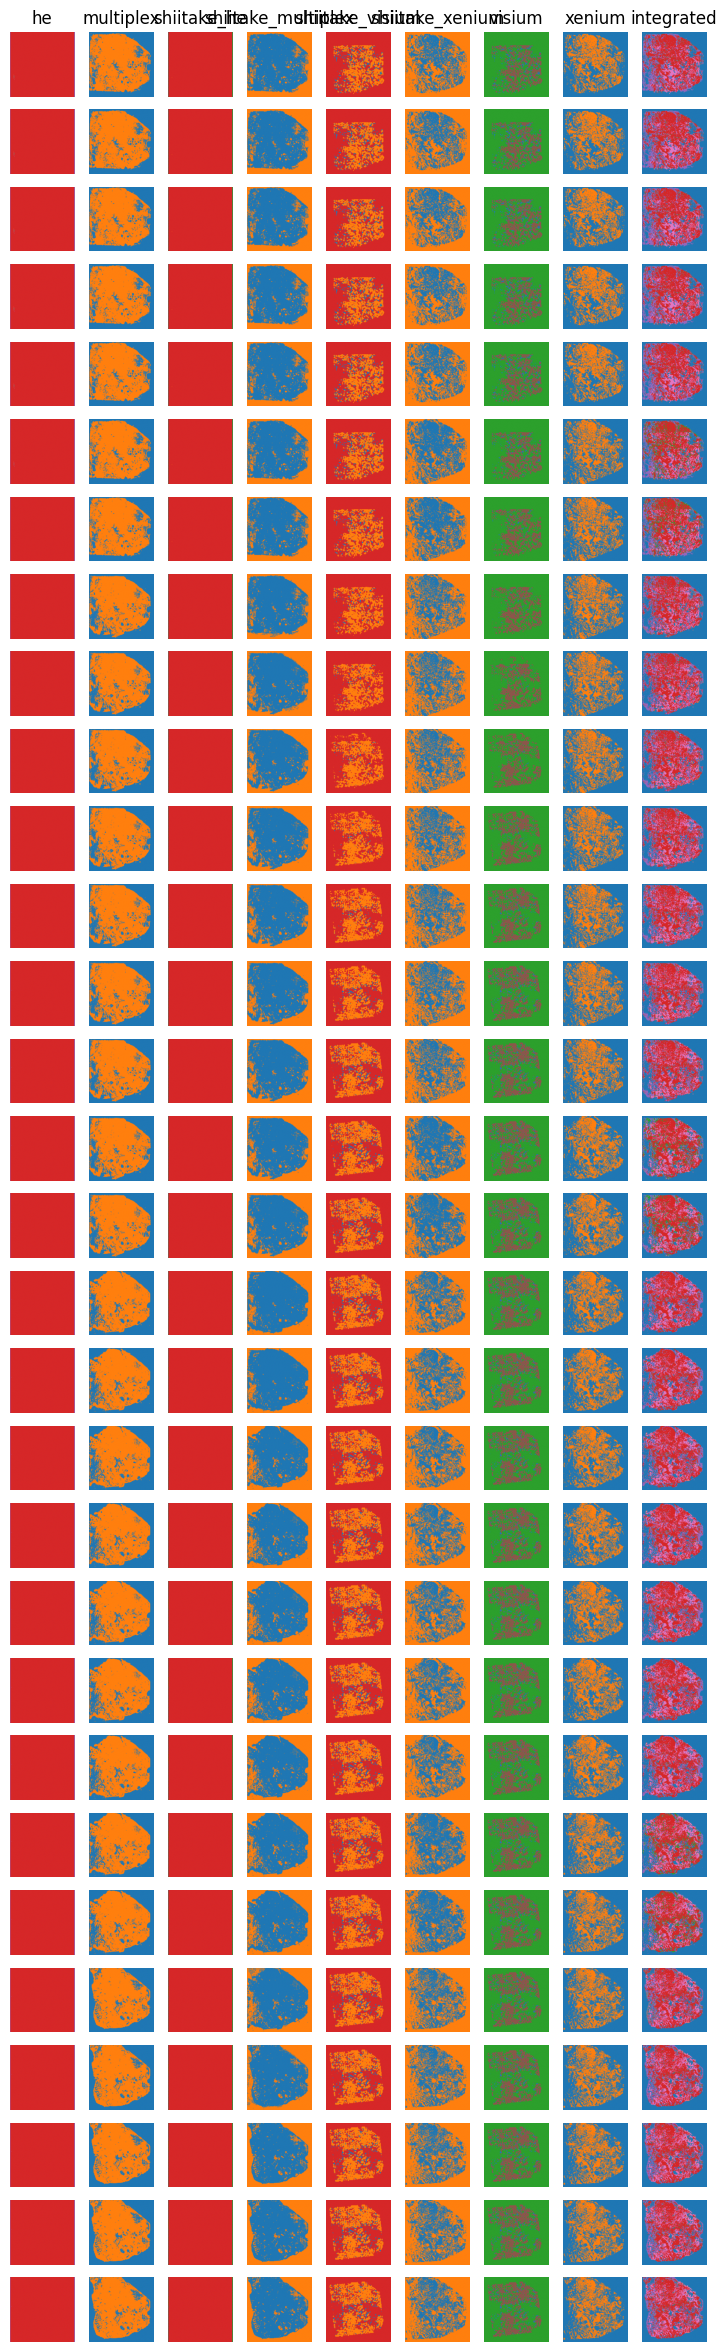

In [41]:
mushroom.display_volumes()

In [42]:
dtype_to_df = mushroom.calculate_cluster_intensities()
dtype_to_df.keys()

dict_keys(['he', 'multiplex', 'shiitake_he', 'shiitake_multiplex', 'shiitake_visium', 'shiitake_xenium', 'visium', 'xenium'])

In [43]:
dtype_to_df['visium']

A2M    A4GALT      AAAS      AACS     AADAT     AAGAB      AAK1  \
0   1.416638  0.634937  0.643221  0.551127  0.575716  0.461384  0.714603   
1   2.394575  1.154385  1.231952  0.986223  1.118078  0.859422  1.298027   
2   2.109401  1.000296  1.065300  0.852840  0.975423  0.747961  1.134646   
3   1.702017  0.798288  0.832291  0.672929  0.739551  0.592013  0.884412   
4   2.927617  1.428610  1.519876  1.251041  1.407186  1.062296  1.627951   
5   3.081810  1.507025  1.605458  1.323017  1.482141  1.114760  1.724561   
6   3.129590  1.535435  1.742397  1.338627  1.531034  1.128671  1.761037   
7   4.487280  2.240677  2.415880  2.001671  2.248209  1.689096  2.586274   
8   2.615044  1.264619  1.345760  1.089922  1.235531  0.941547  1.440782   
9   2.533841  1.224696  1.313422  1.056448  1.195938  0.893708  1.389207   
10  2.319022  1.115124  1.192310  0.948101  1.077248  0.832316  1.257227   
11  2.475529  1.194688  1.266487  1.023559  1.159377  0.894762  1.359306   
12  2.843938  1.372486  1.485542  1.187959  1.358611  1.019591  1.596281   
13  2.012029  0.942729  0.992946  0.796158  0.890948  0.714104  1.068242   

       AAMDC      AAMP      AAR2  ...   ZSCAN30    ZSWIM7    ZSWIM8    ZSWIM9  \
0   0.598332  0.884479  0.429178  ...  0.496512  0.408811  0.592993  0.613896   
1   1.157272  1.588223  0.808756  ...  0.940176  0.847781  1.123570  1.049557   
2   1.000327  1.381444  0.700390  ...  0.810627  0.733312  0.986881  0.912640   
3   0.779925  1.087952  0.541843  ...  0.638131  0.528365  0.741991  0.743198   
4   1.452389  1.977910  1.028876  ...  1.169020  1.106889  1.446326  1.278943   
5   1.535466  2.081976  1.092779  ...  1.228126  1.182786  1.530387  1.346725   
6   1.603967  2.126860  1.153811  ...  1.292224  1.173994  1.473397  1.415778   
7   2.310736  3.120888  1.677467  ...  1.823847  1.887896  2.324399  1.982671   
8   1.278431  1.748125  0.905404  ...  1.032452  0.959639  1.276499  1.143033   
9   1.246044  1.689133  0.871470  ...  0.999219  0.913696  1.213758  1.110323   
10  1.119865  1.534901  0.782433  ...  0.910434  0.813501  1.088883  1.014259   
11  1.201623  1.643565  0.846353  ...  0.970949  0.900260  1.199780  1.079908   
12  1.397083  1.924582  1.016552  ...  1.106968  1.078168  1.426350  1.250295   
13  0.932605  1.280274  0.635786  ...  0.750039  0.662995  0.919353  0.855609   

        ZW10      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
0   0.441061  0.641295  0.564339  0.628768  1.139370  0.748718  
1   0.869892  1.149830  1.052104  1.139089  1.998774  1.500439  
2   0.753652  1.016232  0.910077  0.985352  1.740734  1.292268  
3   0.561810  0.798088  0.720290  0.783697  1.392395  0.967264  
4   1.103966  1.430286  1.325575  1.413043  2.468145  1.883003  
5   1.171155  1.518432  1.395863  1.475496  2.592939  1.990384  
6   1.159395  1.518900  1.432231  1.610228  2.701869  2.038308  
7   1.773417  2.245674  2.113385  2.229700  3.879967  3.071549  
8   0.981450  1.275778  1.169831  1.244838  2.190595  1.661515  
9   0.931142  1.223897  1.122321  1.223959  2.130848  1.589368  
10  0.841253  1.113750  1.017602  1.097540  1.934270  1.444548  
11  0.921657  1.208815  1.102422  1.168769  2.065965  1.567237  
12  1.074216  1.382639  1.270471  1.383395  2.377499  1.823260  
13  0.702935  0.935088  0.847039  0.913265  1.628750  1.203707  

[14 rows x 8587 columns]

In [44]:
dtype_to_df['shiitake_visium']

A2M    A4GALT      AAAS      AACS     AADAT     AAGAB      AAK1  \
0  2.172232  0.986229  1.255261  0.903581  0.993443  0.837296  1.219518   
1  1.440380  0.631166  0.833152  0.615455  0.648921  0.536713  0.796936   
2  2.424804  1.090386  1.412750  0.992879  1.111683  0.938640  1.379570   
3  2.353602  1.088966  1.364606  0.985531  1.076770  0.907573  1.331273   
4  4.038479  1.959881  2.381064  1.708872  1.913473  1.603013  2.381161   
5  2.532635  1.178911  1.479092  1.052823  1.164783  0.975291  1.443364   
6  1.048904  0.457163  0.598251  0.403705  0.457147  0.335057  0.546434   
7  2.579436  1.219541  1.520805  1.121360  1.207757  0.995087  1.478643   
8  2.043783  0.926136  1.173213  0.861012  0.912646  0.792389  1.137394   

      AAMDC      AAMP      AAR2  ...   ZSCAN30    ZSWIM7    ZSWIM8    ZSWIM9  \
0  1.114604  1.568809  0.794051  ...  0.877663  0.834328  1.040700  0.887713   
1  0.692327  1.023287  0.458830  ...  0.554334  0.514212  0.716594  0.526553   
2  1.251137  1.766649  0.920871  ...  0.973621  0.954276  1.165114  1.005602   
3  1.217210  1.709074  0.879120  ...  0.966853  0.912047  1.125088  0.983213   
4  2.138793  2.971978  1.714242  ...  1.685669  1.672905  1.956629  1.859506   
5  1.321466  1.848663  0.979711  ...  1.036017  1.007699  1.218614  1.081417   
6  0.480963  0.736676  0.353730  ...  0.378442  0.383537  0.501967  0.371006   
7  1.327632  1.875310  0.991560  ...  1.096909  1.005161  1.235709  1.106809   
8  1.046911  1.487605  0.711790  ...  0.838551  0.763991  0.943517  0.813718   

       ZW10      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
0  0.844471  1.078101  0.985693  1.053363  1.898575  1.477064  
1  0.528743  0.722782  0.614215  0.637871  1.274726  0.970792  
2  0.961210  1.209985  1.100165  1.203716  2.114387  1.644309  
3  0.920467  1.167458  1.080598  1.148825  2.068114  1.610359  
4  1.668989  2.028610  1.983021  2.078803  3.609946  2.809217  
5  1.011663  1.260361  1.167165  1.253305  2.225930  1.728884  
6  0.413200  0.505578  0.421374  0.503807  0.856146  0.674921  
7  1.009955  1.295826  1.213352  1.258747  2.317116  1.791492  
8  0.783676  1.003939  0.904810  0.977282  1.777365  1.395207  

[9 rows x 8587 columns]

In [45]:
dtype_to_df = mushroom.calculate_cluster_intensities(projection_dtype='visium')
dtype_to_df.keys()

dict_keys(['he', 'multiplex', 'shiitake_he', 'shiitake_multiplex', 'shiitake_visium', 'shiitake_xenium', 'visium', 'xenium'])

In [47]:
dtype_to_df['shiitake_xenium']

ABCC11      ACE2     ACKR1     ACTA2     ACTG2    ADAM28   ADAMTS1  \
0  0.887028  0.222806  0.168360  1.647631  1.971204  0.919165  0.457067   
1  0.923107  0.232772  0.230542  1.735356  2.105280  1.006491  0.457914   
2  0.838584  0.233735  0.152357  1.556527  1.874864  0.868136  0.415533   
3  0.889864  0.205859  0.164275  1.640212  1.964478  0.914229  0.463970   
5  0.901572  0.243634  0.203620  1.708276  2.043858  0.966250  0.444405   

     ADGRE1    ADGRL4     ADH1C  ...      TRAC     TREM2   TSPAN19     UBE2C  \
0  1.055524  1.244794  0.831239  ...  0.890535  0.804505  0.750903  1.180234   
1  1.132642  1.292482  0.909931  ...  0.913817  0.878627  0.797139  1.263633   
2  1.023560  1.140138  0.810150  ...  0.854276  0.749764  0.704074  1.118231   
3  1.037164  1.252625  0.816965  ...  0.880149  0.791103  0.756151  1.170457   
5  1.121024  1.254687  0.900486  ...  0.910997  0.855901  0.754943  1.228952   

       UMOD     UPK3B      VCAN     VSIG4     VWA5A       VWF  
0  0.527434  0.525505  1.242199  0.833261  0.481574  0.743600  
1  0.573319  0.567308  1.321780  0.906440  0.509675  0.803749  
2  0.477417  0.529919  1.166532  0.786883  0.465009  0.678268  
3  0.533490  0.508644  1.242891  0.831768  0.469905  0.747517  
5  0.535463  0.584375  1.276719  0.879898  0.504662  0.764722  

[5 rows x 377 columns]

In [48]:
dtype_to_df = mushroom.calculate_cluster_intensities(projection_dtype='shiitake_visium')
dtype_to_df.keys()

dict_keys(['he', 'multiplex', 'shiitake_he', 'shiitake_multiplex', 'shiitake_visium', 'shiitake_xenium', 'visium', 'xenium'])

In [49]:
dtype_to_df['xenium']

ABCC11      ACE2     ACKR1     ACTA2     ACTG2    ADAM28   ADAMTS1  \
0  0.882674 -0.077598  0.326969  1.488860  1.937240  1.647700  1.261233   
1  0.910353 -0.071650  0.333646  1.534017  1.990279  1.708380  1.290737   
2  0.910282 -0.068369  0.341188  1.521128  1.969823  1.648493  1.267618   
3  0.780696 -0.105686  0.309991  1.370748  1.766665  1.524483  1.143642   
4  0.798081 -0.065053  0.358500  1.380043  1.750559  1.443051  1.066103   
5  0.825671 -0.076787  0.285838  1.432906  1.886741  1.614022  1.214790   

     ADGRE1    ADGRL4     ADH1C  ...      TRAC     TREM2   TSPAN19     UBE2C  \
0  1.198923  1.535514  0.582218  ...  0.959717  1.004654  0.961431  0.974311   
1  1.201908  1.598531  0.603320  ...  0.990998  1.027122  0.981647  0.985511   
2  1.237037  1.534776  0.595614  ...  0.962728  1.017956  0.992716  0.985866   
3  1.063163  1.442179  0.524838  ...  0.882576  0.908143  0.893482  0.895212   
4  1.114701  1.305333  0.480382  ...  0.821186  0.865408  0.929299  0.867596   
5  1.190374  1.480178  0.561801  ...  0.911648  0.985101  0.958469  0.948946   

       UMOD     UPK3B      VCAN     VSIG4     VWA5A       VWF  
0  0.891819  1.129478  1.813407  1.434700  1.739234  1.158092  
1  0.908450  1.157552  1.831182  1.459542  1.795416  1.196786  
2  0.941451  1.187367  1.845868  1.496343  1.749307  1.161464  
3  0.801250  1.019448  1.635259  1.266097  1.583652  1.032655  
4  0.892347  1.103311  1.625676  1.383982  1.513080  0.930818  
5  0.878223  1.108476  1.792314  1.394222  1.683913  1.118135  

[6 rows x 377 columns]

In [50]:
out_dir = os.path.join(mushroom_dir, 'outputs')
prefix = os.path.join(out_dir, f'clusters')
for dtype in mushroom.dtype_to_volume.keys():
    for i in range(3):
        root = prefix + f'_{dtype}_axis{i}'
        is_probs = False
        volume = mushroom.dtype_to_volume[dtype]
        vis_utils.volume_to_gif(volume, is_probs, root + '_section.gif', axis=i)
        
        if i in [1, 2]:
            rgb = vis_utils.display_labeled_as_rgb(volume[0], preserve_indices=True)
            vis_utils.save_reference_gif(rgb, root + '_ref.gif', axis=i-1)

In [51]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs
